# Predicting temperature

In this exercise, we'll work with historical [temperature](https://www.kaggle.com/budincsevity/szeged-weather/home) data from the Szeged, Hungary area. The dataset we'll use is a Postgres database version of this dataset from Kaggle. To complete this assignment, our Jupyter notebook will contain the solutions to the following tasks:

- Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.
- Then, we will check if our model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, we will discuss the implications of the violations for the correctness of our model.

In [1]:
# Libraries 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.decomposition import PCA 
from sklearn import linear_model
from sqlalchemy import create_engine
import warnings


# Import data

warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weatherinszeged_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

# Preliminary data exploration

To choose the features we use in our first model, we do a brief exploratory analysis here.

In [2]:
df = weatherinszeged_df.copy()

df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


This dataset contains 12 attributes and 96,453 rows that describe the weather pattern captured on a day in Szeged, Hungary from 2006 to 2016. Our target variable, temperature, and explanation variables are floats so we won't have to convert them for the machine learning model. 

In [15]:
df.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [16]:
df.describe(include=['object'])

,summary,preciptype,dailysummary
count,96453,96453,96453
unique,27,3,214
top,Partly Cloudy,rain,Mostly cloudy throughout the day.
freq,31733,85224,20085


Here are some initial observations:
 - On a typical day, the temperature is around 12 degrees celsius and partly cloudly with a chance of rain. 
 - Humidity is ususally around 0.73 g/m^3.
 - Wind speed averages to around 11 km/h.

### Missing Values 

After correcting column datatypes, we will start Exploratory Data Analysis will looking at the percentage of missing datapoints in each column.

In [17]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [18]:
missing_values_table(df)

Your selected dataframe has 12 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


There doesn't appear to be obvious missing values. We will continue by looking into the individual variables. 

### Univariate Analysis

First, let's look at the distribution of our target variable: temperature. Investigating how our target is distributed helps us understand the relationship between the target and the features.

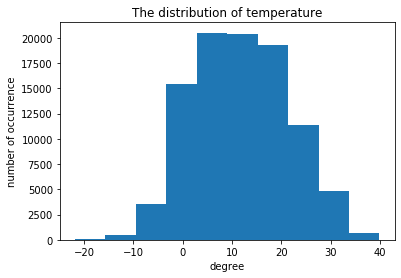

In [5]:
plt.hist(df.temperature)
plt.title("The distribution of temperature")
plt.xlabel("degree")
plt.ylabel("number of occurrence")
plt.show()

In [19]:
df['temperature'].describe()

count    96453.000000
mean        11.932678
std          9.551546
min        -21.822222
25%          4.688889
50%         12.000000
75%         18.838889
max         39.905556
Name: temperature, dtype: float64

Based on the histogram, this distribution looks relatively normal. The mean is also close to the median of the data. 

Let's explore the explanation variables by plotting their distribution. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1243fb240>,
      dtype=object)

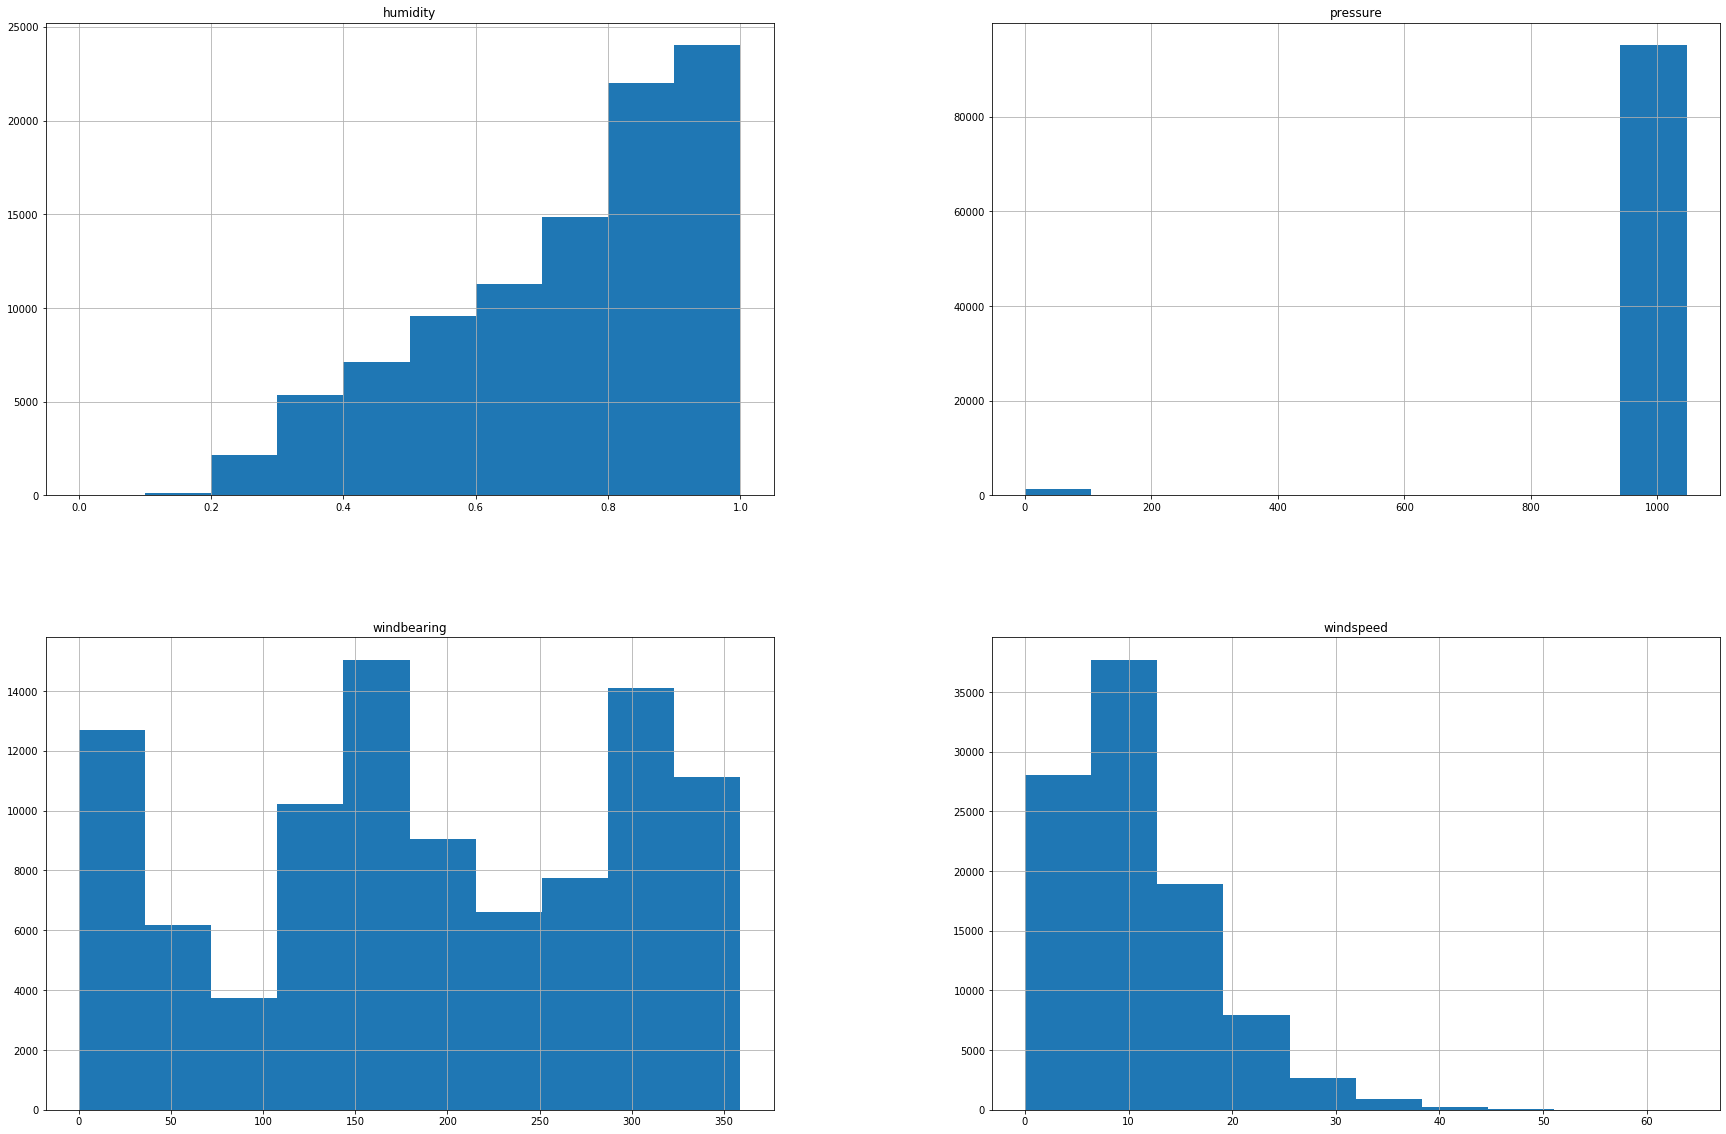

In [11]:
# Plot explanatory variables 

var = df.loc[:,['humidity','windspeed','windbearing','pressure']]

var.hist(figsize=(30,20))

None of these variables look normally distributed. Humidity is heavely skewed to the left. While pressure appears to be a bernoulli distribution. Windbearing somewhat represents a symmetric u-shape and windspeed is skewed to the right. 

### Looking for Relationships

Let's use a heatmap to see the correlation between the variables. 

In [20]:
df.corr()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
temperature,1.000000,0.992629,-0.632255,0.008957,0.029988,0.392847,NaN,-0.005447
apparenttemperature,0.992629,1.000000,-0.602571,-0.056650,0.029031,0.381718,NaN,-0.000219
humidity,-0.632255,-0.602571,1.000000,-0.224951,0.000735,-0.369173,NaN,0.005454
windspeed,0.008957,-0.056650,-0.224951,1.000000,0.103822,0.100749,NaN,-0.049263
windbearing,0.029988,0.029031,0.000735,0.103822,1.000000,0.047594,NaN,-0.011651
visibility,0.392847,0.381718,-0.369173,0.100749,0.047594,1.000000,NaN,0.059818
loudcover,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pressure,-0.005447,-0.000219,0.005454,-0.049263,-0.011651,0.059818,NaN,1.000000


Apparent temperature is highly correlated to temperature. Humidity is the strongest negative correlation to temperature with a score of -0.63.

We will continue to explore their relationship with temperature and explanation variables through scatter plots.

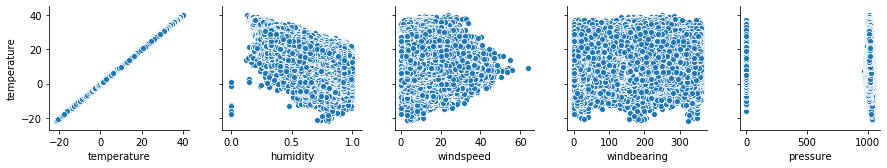

In [21]:
var = df.loc[:,['temperature','humidity','windspeed','windbearing','pressure']]

sns.pairplot(var, y_vars='temperature', x_vars=var.columns.values)

We can observe that temperature doesn't appear to have a linear relationship with any of the explanation variables. 

Let's continue with modeling anyways. 

## Modeling temperature with linear regression


In [13]:
# Y is the target variable
Y = df['temperature']
# X is the feature set which includes

X = df[['humidity','windspeed','windbearing','pressure']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.92643818528538


`LinearRegression()`'s `fit()` method runs the OLS algorithm by default. Since we get the parameters using OLS, we can write our estimated model:

$$ temperature = 37.93 - 32.49\_humidity - 0.2\_windspeed + 0.004\_windbearing - 0.0006\_pressure $$

In [14]:
import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.750e+04
Date:                Fri, 09 Aug 2019   Prob (F-statistic):               0.00
Time:                        23:41:49   Log-Likelihood:            -3.2821e+05
No. Observations:               96453   AIC:                         6.564e+05
Df Residuals:                   96448   BIC:                         6.565e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.9264      0.233    162.709      0.000      37.470      38.383
humidity      -32.4962      0.123   -264.288      0.000     -32.737     -32.255
windspeed      -0.2014      0.003    -57.557      0.000      -0.208      -0.195
windbearing     0.0040      0.000     18.463      0.000       0.004       0.004
pressure       -0.0007      0.000     -3.452      0.001      -0.001      -0.000
==============================================================================
Omnibus:                     3375.432   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3793.297
Skew:                          -0.455   Prob(JB):                         0.00
Kurtosis:                       3.339   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

NOTE: I'm not sure of how to interpret the OSL results. 

# Assumption of linear regression 

Now that we have calculated coefficients for linear regression, we must see if the data and model meets __Gauss Markov Assumptions__ before we can consider the estimated coeffiecents to be valid and reliable. If assumptions are met, the ordinary least square estimate for regression coefficents gives us the best linear unbiased estimate (BLUE) possible. 

Here are the following assumptions we will check:
 - Linearity: the parameters/coefficients we are estimating using the OLS method must be themselves linear. 
 - the error term should be zero on average
 - homoscedasticity
 - low multicollinearity
 - error terms should be uncorrelated with one another
 - features shouldn't be correlated with the errors
 - normality of the errors

### Assumption one: linearity of the model in its coefficients

The first assumption that must be met is that the target variable should be a linear function of the model's coefficients. The relationship between target and features does not have to be a straight line, but can be qudratic or higher order. 

In [25]:
# Y is the target variable
Y = df['temperature']
# X is the feature set which includes

X = df[['humidity','windspeed','windbearing','pressure']]

# create df for checking linearity of coefficients
df_1 = df.copy()

df_1['X'] = X

df_1['X_sq'] = df_1['X']**2

# this is our equation: Y = 1 + 2*X + 3*X^2
df_1["Y"] = 1 + 2*df_1["X"] + 3*df_1["X_sq"]

# we fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df_1[["X","X_sq"]],df_1["Y"])

# predictions of the linear regression
predictions = lrm_example.predict(df_1[["X","X_sq"]])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(df_1["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

ValueError: Wrong number of items passed 4, placement implies 1